In [7]:
import qiskit_machine_learning
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [8]:
df_credit = pd.read_csv('german_credit_data.csv', index_col=[0])
df_credit.head()

Age     Sex  Job Housing Saving accounts Checking account  Credit amount  \
0   67    male    2     own             NaN           little           1169   
1   22  female    2     own          little         moderate           5951   
2   49    male    1     own          little              NaN           2096   
3   45    male    2    free          little           little           7882   
4   53    male    2    free          little           little           4870   

   Duration              Purpose  Risk  
0         6             radio/TV  good  
1        48             radio/TV   bad  
2        12            education  good  
3        42  furniture/equipment  good  
4        24                  car   bad

In [9]:
interval = (18, 25, 35, 60, 120)
cats = ['Student', 'Young', 'Adult', 'Senior']
df_credit["Age_cat"] = pd.cut(df_credit.Age, interval, labels=cats)

In [10]:
df_credit['Saving accounts'] = df_credit['Saving accounts'].fillna('no_inf')
df_credit['Checking account'] = df_credit['Checking account'].fillna('no_inf')

In [11]:
le = preprocessing.LabelEncoder()
df_credit['Sex'] = le.fit_transform(df_credit['Sex'])
df_credit['Housing'] = le.fit_transform(df_credit['Housing'])
df_credit['Saving accounts'] = le.fit_transform(df_credit['Saving accounts'])
df_credit['Checking account'] = le.fit_transform(df_credit['Checking account'])
df_credit['Purpose'] = le.fit_transform(df_credit['Purpose'])
df_credit['Age_cat'] = le.fit_transform(df_credit['Age_cat'])
df_credit['Risk'] = le.fit_transform(df_credit['Risk'])

In [13]:
df_credit['Credit amount'] = np.log(df_credit['Credit amount'])

In [14]:
df_credit.head

<bound method NDFrame.head of      Age  Sex  Job  Housing  Saving accounts  Checking account  Credit amount  \
0     67    1    2        1                2                 0       7.063904   
1     22    0    2        1                0                 1       8.691315   
2     49    1    1        1                0                 2       7.647786   
3     45    1    2        0                0                 0       8.972337   
4     53    1    2        0                0                 0       8.490849   
..   ...  ...  ...      ...              ...               ...            ...   
995   31    0    1        1                0                 2       7.459339   
996   40    1    3        1                0                 0       8.257645   
997   38    1    2        1                0                 2       6.689599   
998   23    1    2        0                0                 0       7.520235   
999   27    1    2        1                1                 1       8.428581  

In [15]:
features = df_credit.drop('Risk', 1).values
labels = df_credit["Risk"].values

/tmp/ipykernel_60/874059793.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  features = df_credit.drop('Risk', 1).values


In [16]:
features = MinMaxScaler().fit_transform(features)
features[:5]

array([[0.85714286, 1.        , 0.66666667, 0.5       , 0.5       ,
        0.        , 0.35871198, 0.02941176, 0.71428571, 0.33333333],
       [0.05357143, 0.        , 0.66666667, 0.5       , 0.        ,
        0.33333333, 0.73718409, 0.64705882, 0.71428571, 0.66666667],
       [0.53571429, 1.        , 0.33333333, 0.5       , 0.        ,
        0.66666667, 0.49450014, 0.11764706, 0.42857143, 0.        ],
       [0.46428571, 1.        , 0.66666667, 0.        , 0.        ,
        0.        , 0.80253892, 0.55882353, 0.57142857, 0.        ],
       [0.60714286, 1.        , 0.66666667, 0.        , 0.        ,
        0.        , 0.69056369, 0.29411765, 0.14285714, 0.        ]])

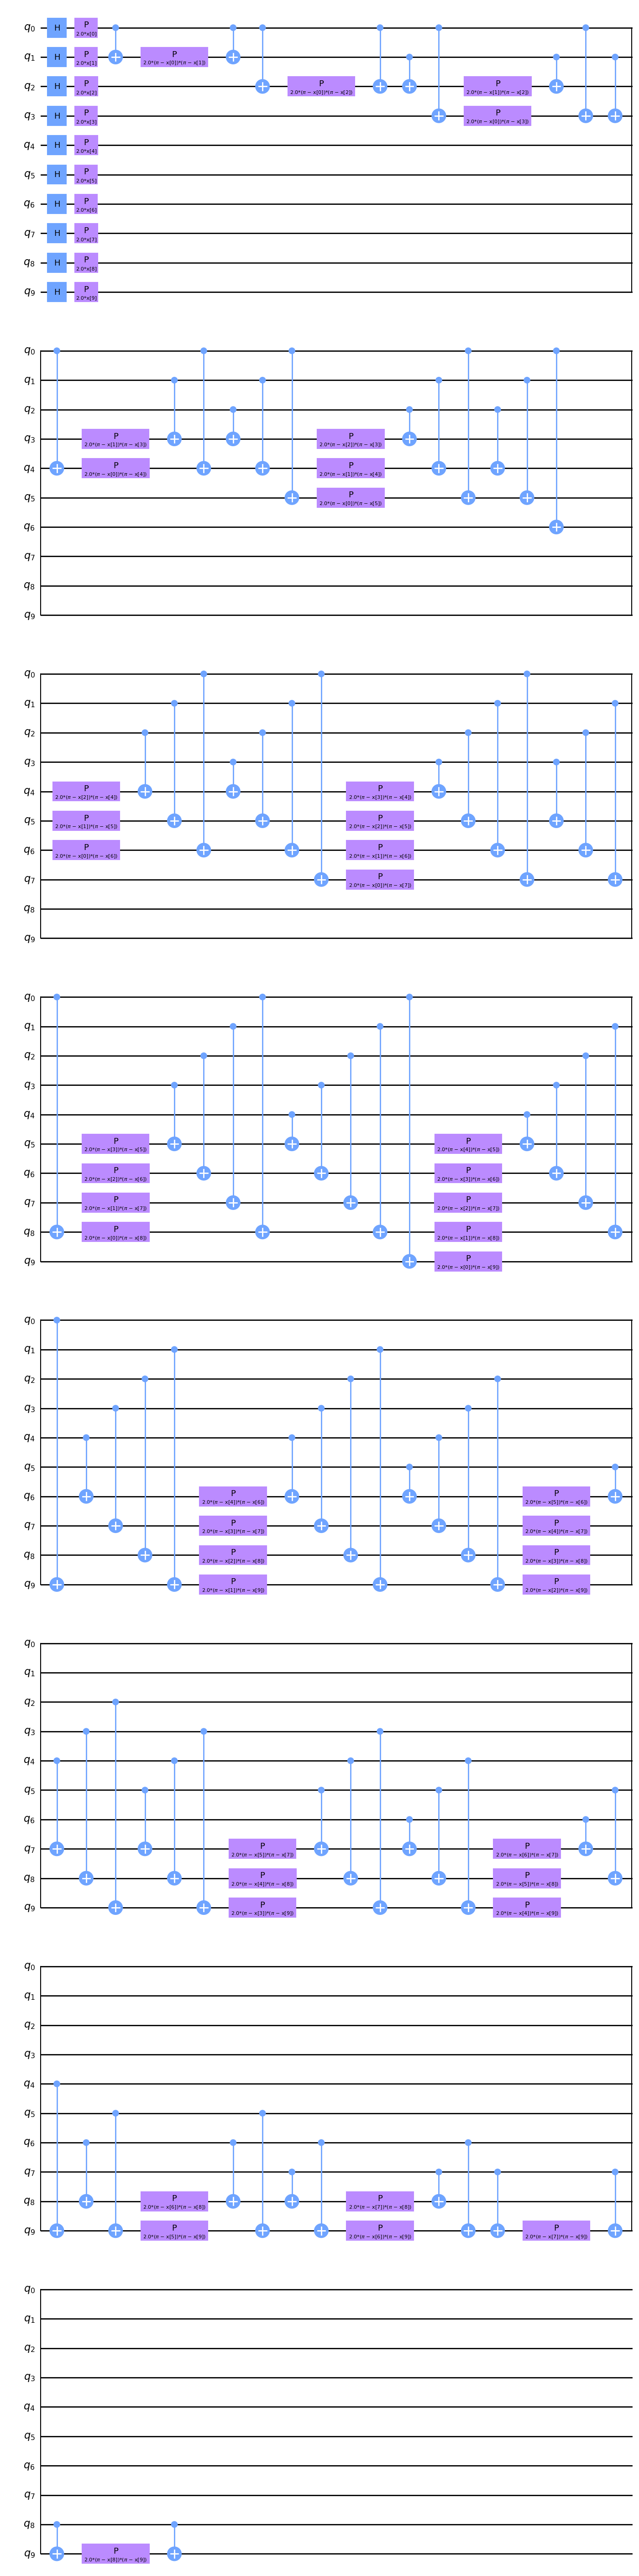

In [17]:
from qiskit.circuit.library import ZZFeatureMap
num_features = features.shape[1]
feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", fold=20)

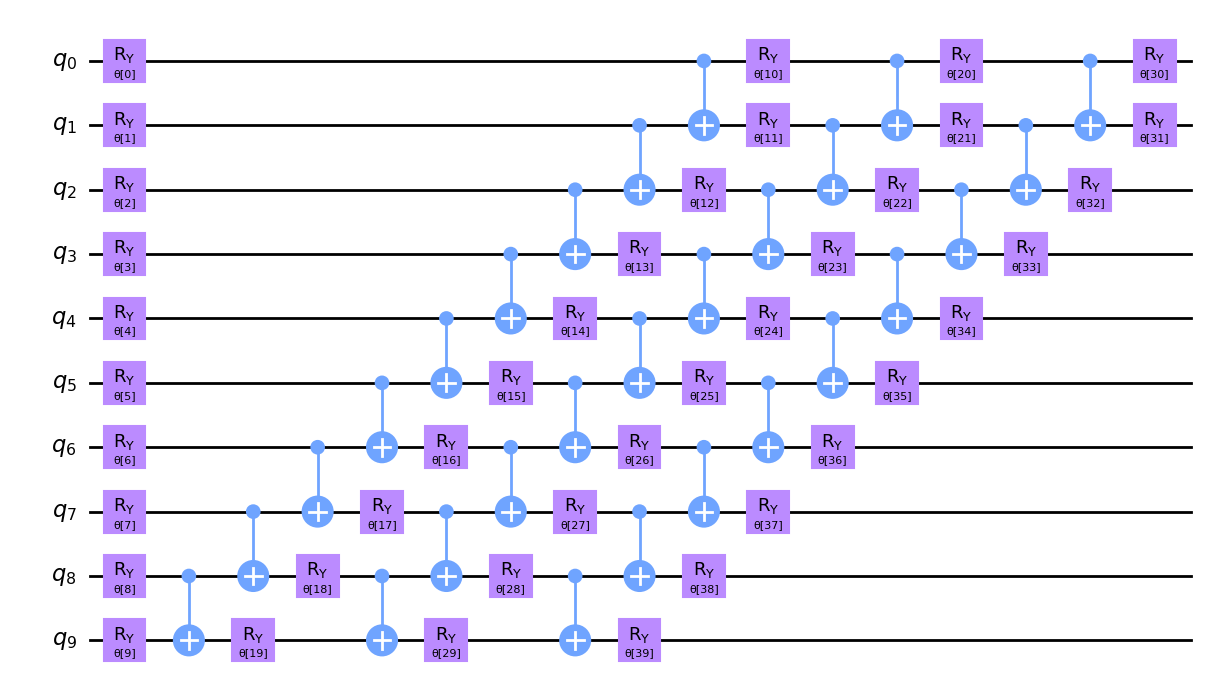

In [18]:
from qiskit.circuit.library import RealAmplitudes
ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
ansatz.decompose().draw(output="mpl", fold=20)

In [19]:
df_credit.shape

(1000, 11)

In [20]:
features.shape

(1000, 10)

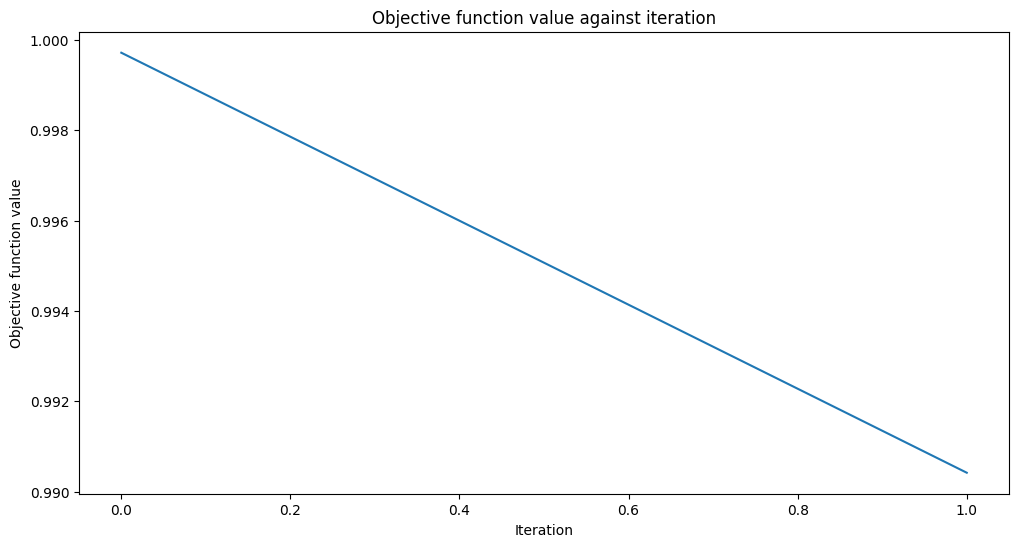

Training time: 132 seconds
Accuracy on the training data: 57.99999999999999%
Accuracy on the testing data: 63.0%


In [21]:
from qiskit.algorithms.optimizers import COBYLA

 

optimizer = COBYLA(maxiter=2)

 

from qiskit.primitives import Sampler

 

sampler = Sampler()

 

from matplotlib import pyplot as plt
from IPython.display import clear_output

 

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

 

 

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

from sklearn.model_selection import train_test_split
from qiskit.utils import algorithm_globals

 

algorithm_globals.random_seed = 123
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

 

import time
from qiskit_machine_learning.algorithms.classifiers import VQC

 

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

 

# clear objective value history
objective_func_vals = []

 

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

 

print(f"Training time: {round(elapsed)} seconds")

 

train_acc = vqc.score(train_features, train_labels)
test_acc = vqc.score(test_features, test_labels)
print(f'Accuracy on the training data: {round(train_acc, 2) * 100}%')
print(f'Accuracy on the testing data: {round(test_acc, 2) * 100}%')